In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
round_num_list = np.arange(1, 11)
mode = 2 # 1: with hidden confounder; 2: no hidden confounder

In [ ]:
methods = ['NegDRO', 'ERM', 'ICP', 'EILLS', 'Anchor']
p_list = [5,10,15,20,25,30,35,40,50,60,70,80,90,100]
err_dict = {m: {p: [] for p in p_list} for m in methods}
t_dict = {m: {p: [] for p in p_list} for m in methods}

for r in round_num_list:
    with open(f'results-exp2/results/main_varyp_mode{mode}_round{r}.pkl', 'rb') as f:
        results = pickle.load(f)
        b_results = results['b_results']
        time_results = results['time_results']
    for m in methods:
        for p in p_list:
            beta_star = np.zeros(p)
            beta_star[0], beta_star[2] = 0.5, -0.5
            b_runs = b_results[m][p]
            time_runs = time_results[m][p]
            thres = 0.05
            for b_run in b_runs:
                if b_run is None:
                    continue
                else:
                    err = np.linalg.norm(b_run - beta_star)
                    err_dict[m][p].append(err)
            for time_run in time_runs:
                if time_run is None:
                    continue
                else:
                    t_dict[m][p].append(time_run)

In [4]:
err_mean = {m: [np.mean(err_dict[m][p]) for p in p_list if err_dict[m][p]] for m in methods}
err_std = {m: [np.std(err_dict[m][p]) for p in p_list if err_dict[m][p]] for m in methods}
time_mean = {m: [np.mean(t_dict[m][p]) for p in p_list if t_dict[m][p]] for m in methods}

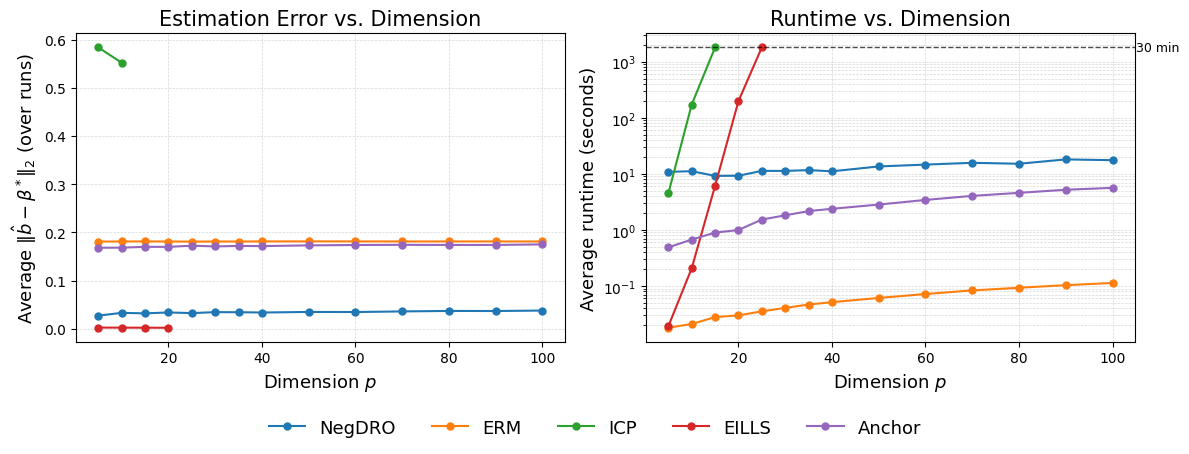

In [ ]:
fig, (ax_err, ax_time) = plt.subplots(1, 2, figsize=(12, 4.5), sharex=False)

legend_lines = []
legend_labels = []

# ---------- Left: Estimation error vs p ----------
for m in methods:
    # p’s with error data for this method (matches how you built err_mean[m])
    ps_m_err = [p for p in p_list if err_dict[m][p]]
    ys_m_err = np.asarray(err_mean[m], dtype=float)
    ys_m_std = np.asarray(err_std[m], dtype=float)
    if len(ps_m_err) == 0:
        continue
    line, = ax_err.plot(ps_m_err, ys_m_err, marker='o', linewidth=1.5, markersize=5, label=m)
    legend_lines.append(line); legend_labels.append(m)

ax_err.set_xlabel("Dimension $p$", fontsize=13)
ax_err.set_ylabel(r"Average $\|\hat{b} - \beta^*\|_2$ (over runs)", fontsize=13)
ax_err.set_title("Estimation Error vs. Dimension", fontsize=15)
ax_err.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.5)

# ---------- Right: Runtime vs p (insert 1800s at first missing) ----------
TIME_LIMIT = 1800.0
for m in methods:
    # presence per p for runtime
    time_present = {p: bool(t_dict[m][p]) for p in p_list}

    # compressed (p, mean time) pairs you already computed
    ps_m_time = [p for p in p_list if time_present[p]]
    ys_m_time = np.asarray(time_mean[m], dtype=float)
    

    # find the first p where time is missing
    first_timeout_p = None
    for p in p_list:
        if not time_present[p]:
            first_timeout_p = p
            break

    # build plotting arrays:
    Ps_plot = []
    Ts_plot = []

    if first_timeout_p is None:
        # no timeout: just plot available points
        Ps_plot = np.array(ps_m_time, dtype=float)
        Ts_plot = ys_m_time.astype(float)
    else:
        # points strictly before the first timeout p
        mask_before = np.array(ps_m_time, dtype=float) < float(first_timeout_p)
        Ps_before = np.array(ps_m_time, dtype=float)[mask_before]
        Ts_before = ys_m_time.astype(float)[mask_before]

        # add the timeout point at the first missing p
        Ps_plot = np.concatenate([Ps_before, [float(first_timeout_p)]])
        Ts_plot = np.concatenate([Ts_before, [TIME_LIMIT]])

    if len(Ps_plot) > 0:
        ax_time.plot(Ps_plot, Ts_plot, marker='o', linewidth=1.5, markersize=5, label=m)

# Draw a horizontal time-limit line and label it
ax_time.axhline(TIME_LIMIT, color='k', linestyle='--', linewidth=1, alpha=0.7, label='_nolegend_')
ax_time.text(0.995, TIME_LIMIT, " 30 min", va='center', ha='left', fontsize=9,
             transform=ax_time.get_yaxis_transform())

ax_time.set_xlabel("Dimension $p$", fontsize=13)
ax_time.set_ylabel("Average runtime (seconds)", fontsize=13)
ax_time.set_title("Runtime vs. Dimension", fontsize=15)
ax_time.set_yscale('log')
ax_time.grid(True, which="both", ls="--", linewidth=0.5, alpha=0.5)
# If runtimes span orders of magnitude, you can use:
# ax_time.set_yscale('log')

# ---------- Shared legend at bottom center ----------
fig.legend(
    legend_lines, legend_labels,
    loc='lower center', bbox_to_anchor=(0.5, -0.02), fontsize=13,
    ncol=min(5, len(legend_labels)), frameon=False, title=None,
)

fig.tight_layout(rect=[0, 0.08, 1, 1])  # leave space for bottom legend
# fig.savefig('summary_p_T_mode2.png', dpi=300, bbox_inches='tight')
plt.show()
